### In this notebook, I will train multilayer neural network in TensorFlow and Keras. I will use MNIST Hand written digit dataset. The goal is to build a model to recognize the hand written digit. 

In [3]:
# Load Required packages

import os
import sys
import cv2
import imageio
import pylab
import keras
import numpy as np
import pandas as pd
from scipy.misc import imread
from sklearn.metrics import accuracy_score
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

seed = 128
rng = np.random.RandomState(seed)

## Load & Process the Dataset

train: (49000, 28, 28)
test: (21000, 28, 28)


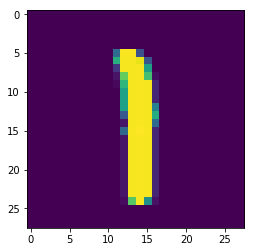

In [4]:
# Read Test / Train Images

train = pd.read_csv('train.csv')
test = pd.read_csv('Test.csv')

#Read Images: Images are located in ./Images/train/*.png format

def read_images(path_to_dir, dataset = train):
    temp = []
    for image in dataset.filename:
        image_path = os.path.join(path_to_dir,image)
        img = imageio.imread(image_path, as_gray=True)
        img = img.astype('float32')
        temp.append(img)
    return np.stack(temp)
    
X_train = read_images("./Images/train/", train)
X_test = read_images("./Images/test/", test)

Y_train = np.array(train.label.tolist())

print "train:", X_train.shape
print "test:", X_test.shape

plt.imshow(X_train[2]);

### Alternatively, load Keras MNIST dataset

(60000, 28, 28)
(60000,)


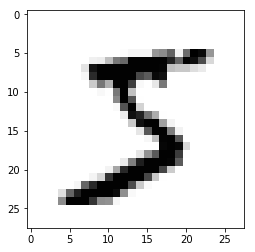

In [7]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

print X_train.shape
print y_train.shape

# normalize x
X_train = X_train.astype(float) / 255.
X_test = X_test.astype(float) / 255.

# reserve the last 10000 training examples for validation
X_train, X_val = X_train[:-10000], X_train[-10000:]
y_train, y_val = y_train[:-10000], y_train[-10000:]

plt.imshow(X_train[0], cmap="Greys");

In [8]:
print "Train:", X_train.shape[0], "images. Each with the dim of", X_train.shape[1], "X", X_train.shape[2]
print "Test:", X_test.shape[0], "images. Each with the dim of", X_test.shape[1], "X", X_test.shape[2]

Train: 50000 images. Each with the dim of 28 X 28
Test: 10000 images. Each with the dim of 28 X 28


***1.  This means that there are 50,000 training images. Each with the dimension of 28 X 28 pixels. We need to flatten this so that each training image is one row and number of columns
are 728 (= 28 x 28). This will make 728 input features for our model***

***2.  The output is a vector containig the true digit with values in [0,1,2,3,4,5,6,7,8,9] (10 classes). For modeling purpose, we need hot encode the output.***

In [9]:
# Reshape the training, validate and test examples + Hot encode Y labels

def preprocess(X,y):
    X_out = np.reshape(X,(X.shape[0],X.shape[1]*X.shape[2]))
    n_values = np.max(y) + 1
    y_hot = np.eye(n_values)[y]
    return X_out, y_hot

X_train_flatten, y_train_one_hot = preprocess(X_train, y_train)
X_val_flatten, y_val_one_hot = preprocess(X_val, y_val)
X_test_flatten, y_test_one_hot = preprocess(X_test, y_test)

print "Before flattening:", X_train.shape
print "After flattening:", X_train_flatten.shape

print "Before Hot Encoding:", y_train.shape
print "After Hot Encoding:",y_train_one_hot.shape

Before flattening: (50000, 28, 28)
After flattening: (50000, 784)
Before Hot Encoding: (50000,)
After Hot Encoding: (50000, 10)


In [10]:
def batch_creator(batch_size, x_train, y_train):
    """Create batch with random samples and return appropriate format"""
    
    batch_mask = rng.choice(x_train.shape[0], batch_size)
    batch_x = x_train[batch_mask]
    batch_y = y_train[batch_mask]   
    return batch_x, batch_y

## 1) Logistic Regression Model:

*** Model: W.X + b ***

- X = [50000, 784]
- W = [784, 10] 
- b = [50000,10]
- Y = [50000,10]

In [11]:
batch_size = 100
learning_rate = 0.0001
epochs = 100
total_batch = int(X_train_flatten.shape[0]/batch_size)


# creating placeholders
x = tf.placeholder(tf.float32, shape=[None, X_train_flatten.shape[1]])
y = tf.placeholder(tf.float32, shape=[None, y_train_one_hot.shape[1]])

# creating variables
W = tf.Variable(tf.zeros([X_train_flatten.shape[1], y_train_one_hot.shape[1]]))
b = tf.Variable(tf.zeros(y_train_one_hot.shape[1]))
     
# initializing the model
y_pred = tf.matmul(x,W) + b
 
# Defining Cost Function
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = y_pred, labels = y))
  
# Implementing Gradient Descent Algorithm
train_op = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cross_entropy)

In [14]:
# Initializing the session
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
 
    # Creating batches of data for epochs
    for epoch in range(epochs):
        avg_cost = 0 
        for i in range(total_batch):
            batch_x, batch_y = batch_creator(batch_size, X_train_flatten, y_train_one_hot)
            _, c = sess.run([train_op, cross_entropy], feed_dict = {x: batch_x, y: batch_y})
            avg_cost += c / total_batch
        if epoch%10 == 0:    
            print "Epoch:", (epoch), "cost =", "{:.5f}".format(avg_cost)
  

    print "\nTraining complete!"
     
    # Print Accuracy of the model
    pred_temp = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(pred_temp, "float"))
    print "Validation Accuracy:", accuracy.eval({x: X_val_flatten, y:y_val_one_hot})
    print "Test Accuracy:", accuracy.eval({x: X_test_flatten, y:y_test_one_hot})
    
    predict = tf.argmax(y_pred, 1)
    pred = predict.eval({x: X_test_flatten})

Epoch: 0 cost = 1.62157
Epoch: 10 cost = 0.37400
Epoch: 20 cost = 0.31316
Epoch: 30 cost = 0.29382
Epoch: 40 cost = 0.28256
Epoch: 50 cost = 0.27833
Epoch: 60 cost = 0.27030
Epoch: 70 cost = 0.27045
Epoch: 80 cost = 0.26334
Epoch: 90 cost = 0.25327

Training complete!
Validation Accuracy: 0.9314
Test Accuracy: 0.9262


## Multilayer Perceptron Model:

*** Model Outline (Computational Graph):***

* Hidden Layer1 Z1 = W1*X + b1 ---> A1 = ReLu(Z1)
* Hidden Layer2 Z2 = W2*A1 + b2 ---> A2 = ReLu(Z2)
* Output Layter = W3*A2 + b3 


*** Run the model: ***

- for each epoch, do:
- for each batch, do:
- create pre-processed batch
- run optimizer by feeding batch
- find cost and reiterate to minimize



In [17]:
# number of neurons in each layer
input_num_units = 28*28
hidden_num_units1 = 200
hidden_num_units2 = 300
output_num_units = 10
epochs = 200
batch_size = 512
learning_rate = 0.02


# define input placeholders
x = tf.placeholder(tf.float32, [None, input_num_units])
y = tf.placeholder(tf.float32, [None, output_num_units])


# define weights and biases of the neural network
weights = {
    'hidden1': tf.Variable(tf.random_normal([input_num_units, hidden_num_units1], seed=seed)),
    'hidden2': tf.Variable(tf.random_normal([hidden_num_units1, hidden_num_units2], seed=seed)),
    'output': tf.Variable(tf.random_normal([hidden_num_units2, output_num_units], seed=seed))}

biases = {
    'hidden1': tf.Variable(tf.random_normal([hidden_num_units1], seed=seed)),
    'hidden2': tf.Variable(tf.random_normal([hidden_num_units2], seed=seed)),
    'output': tf.Variable(tf.random_normal([output_num_units], seed=seed))}

# Define Layers
hidden_layer1 = tf.add(tf.matmul(x, weights['hidden1']), biases['hidden1'])
hidden_layer1 = tf.nn.relu(hidden_layer1)

hidden_layer2 = tf.add(tf.matmul(hidden_layer1, weights['hidden2']), biases['hidden2'])
hidden_layer2 = tf.nn.relu(hidden_layer2)

output_layer = tf.matmul(hidden_layer2, weights['output']) + biases['output']

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = output_layer, labels = y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

In [18]:
%%time 

init = tf.global_variables_initializer()

with tf.Session() as sess:

    sess.run(init)
    
    for epoch in range(epochs):
        avg_cost = 0
        total_batch = int(X_train_flatten.shape[0]/batch_size)
        for i in range(total_batch):
            batch_x, batch_y = batch_creator(batch_size, X_train_flatten, y_train_one_hot)
            _, c = sess.run([optimizer, cost], feed_dict = {x: batch_x, y: batch_y})
            avg_cost += c / total_batch
        if epoch%50 == 0:    
            print "Epoch:", (epoch), "cost =", "{:.5f}".format(avg_cost)
    
    print "\nTraining complete!"
    
    pred_temp = tf.equal(tf.argmax(output_layer, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(pred_temp, "float"))
    print "Validation Accuracy:", accuracy.eval({x: X_val_flatten, y:y_val_one_hot})
    print "Test Accuracy:", accuracy.eval({x: X_test_flatten, y:y_test_one_hot})
    
    predict = tf.argmax(output_layer, 1)
    pred = predict.eval({x: X_test_flatten})

Epoch: 0 cost = 115.37379
Epoch: 50 cost = 0.55731
Epoch: 100 cost = 0.52511
Epoch: 150 cost = 0.47539

Training complete!
Validation Accuracy: 0.9751
Test Accuracy: 0.9759
CPU times: user 8min 7s, sys: 42.5 s, total: 8min 49s
Wall time: 1min 44s


### Building Model in Keras

In [28]:
import keras
from keras.models import Sequential
import keras.layers as ll

model = Sequential(name="digit")

model.add(ll.InputLayer([28, 28]))

model.add(ll.Flatten())

# network body
model.add(ll.Dense(200))
model.add(ll.Activation('relu'))

model.add(ll.Dense(300))
model.add(ll.Activation('relu'))

# output layer: 10 neurons for each class with softmax
model.add(ll.Dense(10, activation='softmax'))

# categorical_crossentropy is your good old crossentropy but applied for one-hot-encoded vectors
model.compile("adam", "categorical_crossentropy", metrics=["accuracy"])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 200)               157000    
_________________________________________________________________
activation_5 (Activation)    (None, 200)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 300)               60300     
_________________________________________________________________
activation_6 (Activation)    (None, 300)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 10)                3010      
Total params: 220,310
Trainable params: 220,310
Non-trainable params: 0
_________________________________________________________________


In [29]:
%%time
model.fit(X_train, y_train_one_hot, validation_data=(X_val, y_val_one_hot), epochs=200, batch_size = 512);

Train on 50000 samples, validate on 10000 samples
Epoch 1/200
50000/50000 [==============================] - 1s 21us/step - loss: 0.4920 - acc: 0.8674 - val_loss: 0.1977 - val_acc: 0.9463
Epoch 2/200
50000/50000 [==============================] - 1s 14us/step - loss: 0.1741 - acc: 0.9494 - val_loss: 0.1325 - val_acc: 0.9634
Epoch 3/200
50000/50000 [==============================] - 1s 14us/step - loss: 0.1212 - acc: 0.9646 - val_loss: 0.1133 - val_acc: 0.9667
Epoch 4/200
50000/50000 [==============================] - 1s 14us/step - loss: 0.0904 - acc: 0.9731 - val_loss: 0.0978 - val_acc: 0.9715
Epoch 5/200
50000/50000 [==============================] - 1s 14us/step - loss: 0.0688 - acc: 0.9798 - val_loss: 0.0947 - val_acc: 0.9714
Epoch 6/200
50000/50000 [==============================] - 1s 14us/step - loss: 0.0555 - acc: 0.9842 - val_loss: 0.0842 - val_acc: 0.9754
Epoch 7/200
50000/50000 [==============================] - 1s 15us/step - loss: 0.0439 - acc: 0.9876 - val_loss: 0.0814 - 

50000/50000 [==============================] - 1s 14us/step - loss: 4.5770e-05 - acc: 1.0000 - val_loss: 0.1084 - val_acc: 0.9808
Epoch 59/200
50000/50000 [==============================] - 1s 14us/step - loss: 4.3153e-05 - acc: 1.0000 - val_loss: 0.1105 - val_acc: 0.9804
Epoch 60/200
50000/50000 [==============================] - 1s 14us/step - loss: 4.0432e-05 - acc: 1.0000 - val_loss: 0.1105 - val_acc: 0.9804
Epoch 61/200
50000/50000 [==============================] - 1s 14us/step - loss: 3.7954e-05 - acc: 1.0000 - val_loss: 0.1105 - val_acc: 0.9803
Epoch 62/200
50000/50000 [==============================] - 1s 14us/step - loss: 3.5020e-05 - acc: 1.0000 - val_loss: 0.1107 - val_acc: 0.9807
Epoch 63/200
50000/50000 [==============================] - 1s 14us/step - loss: 3.3099e-05 - acc: 1.0000 - val_loss: 0.1117 - val_acc: 0.9806
Epoch 64/200
50000/50000 [==============================] - 1s 14us/step - loss: 3.0658e-05 - acc: 1.0000 - val_loss: 0.1116 - val_acc: 0.9812
Epoch 65/200

50000/50000 [==============================] - 1s 14us/step - loss: 1.4687e-06 - acc: 1.0000 - val_loss: 0.1339 - val_acc: 0.9801
Epoch 116/200
50000/50000 [==============================] - 1s 14us/step - loss: 1.4001e-06 - acc: 1.0000 - val_loss: 0.1349 - val_acc: 0.9803
Epoch 117/200
50000/50000 [==============================] - 1s 14us/step - loss: 1.3229e-06 - acc: 1.0000 - val_loss: 0.1347 - val_acc: 0.9804
Epoch 118/200
50000/50000 [==============================] - 1s 14us/step - loss: 1.2585e-06 - acc: 1.0000 - val_loss: 0.1354 - val_acc: 0.9805
Epoch 119/200
50000/50000 [==============================] - 1s 14us/step - loss: 1.2004e-06 - acc: 1.0000 - val_loss: 0.1357 - val_acc: 0.9806
Epoch 120/200
50000/50000 [==============================] - 1s 14us/step - loss: 1.1421e-06 - acc: 1.0000 - val_loss: 0.1358 - val_acc: 0.9806
Epoch 121/200
50000/50000 [==============================] - 1s 14us/step - loss: 1.0794e-06 - acc: 1.0000 - val_loss: 0.1362 - val_acc: 0.9804
Epoch 

Epoch 172/200
50000/50000 [==============================] - 1s 14us/step - loss: 1.7911e-07 - acc: 1.0000 - val_loss: 0.1514 - val_acc: 0.9811
Epoch 173/200
50000/50000 [==============================] - 1s 14us/step - loss: 1.7597e-07 - acc: 1.0000 - val_loss: 0.1520 - val_acc: 0.9809
Epoch 174/200
50000/50000 [==============================] - 1s 14us/step - loss: 1.7282e-07 - acc: 1.0000 - val_loss: 0.1523 - val_acc: 0.9807
Epoch 175/200
50000/50000 [==============================] - 1s 14us/step - loss: 1.7099e-07 - acc: 1.0000 - val_loss: 0.1522 - val_acc: 0.9809
Epoch 176/200
50000/50000 [==============================] - 1s 14us/step - loss: 1.6801e-07 - acc: 1.0000 - val_loss: 0.1527 - val_acc: 0.9809
Epoch 177/200
50000/50000 [==============================] - 1s 14us/step - loss: 1.6517e-07 - acc: 1.0000 - val_loss: 0.1526 - val_acc: 0.9809
Epoch 178/200
50000/50000 [==============================] - 1s 14us/step - loss: 1.6304e-07 - acc: 1.0000 - val_loss: 0.1530 - val_acc:

In [30]:
# Save trained weights
model.save("digit_keras_ann_weights.h5")
print("Loss, Accuracy = ", model.evaluate(X_test, y_test_one_hot))

10000/10000 [==============================] - 0s 19us/step
('Loss, Accuracy = ', [0.17446766940470565, 0.9797])


## Convolution Neural Network (CNN) Model:

In [31]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Flatten, Dense

In [32]:
train_samples = 60000
validation_samples = 10000
epoch = 30

# ** Model Begins **
model = Sequential()

model.add(Convolution2D(10, 5, 5, activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPooling2D(2, 2))

model.add(Convolution2D(32, 3, 3, activation='relu'))
model.add(MaxPooling2D(2, 2))

model.add(Flatten())
model.add(Dense(1000, activation='relu'))

model.add(Dense(10, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 24, 24, 10)        260       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 12, 12, 10)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 10, 10, 32)        2912      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 1000)              801000    
_________________________________________________________________
dense_17 (Dense)             (None, 10)                10010     
Total para

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(10, (5, 5), activation="relu", input_shape=(28, 28, 1...)`
  
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu")`
  # This is added back by InteractiveShellApp.init_path()


In [34]:
model.compile(loss='binary_crossentropy', optimizer='rmsprop',metrics=['accuracy'])
model.fit(X_train.reshape(X_train.shape[0], 28, 28, 1), y_train_one_hot, validation_data=(X_val.reshape(X_val.shape[0],28, 28, 1), y_val_one_hot), epochs=10, batch_size = 512)
model.save_weights('digit_keras_cnn_weights.h5')

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 8s 170us/step - loss: 0.0653 - acc: 0.9778 - val_loss: 0.0213 - val_acc: 0.9930
Epoch 2/10
50000/50000 [==============================] - 8s 157us/step - loss: 0.0173 - acc: 0.9943 - val_loss: 0.0173 - val_acc: 0.9942
Epoch 3/10
50000/50000 [==============================] - 8s 161us/step - loss: 0.0111 - acc: 0.9962 - val_loss: 0.0096 - val_acc: 0.9972
Epoch 4/10
50000/50000 [==============================] - 8s 161us/step - loss: 0.0084 - acc: 0.9972 - val_loss: 0.0084 - val_acc: 0.9975
Epoch 5/10
50000/50000 [==============================] - 8s 161us/step - loss: 0.0064 - acc: 0.9980 - val_loss: 0.0084 - val_acc: 0.9975
Epoch 6/10
50000/50000 [==============================] - 8s 161us/step - loss: 0.0050 - acc: 0.9984 - val_loss: 0.0079 - val_acc: 0.9978
Epoch 7/10
50000/50000 [==============================] - 8s 161us/step - loss: 0.0041 - acc: 0.9986 - val_loss: 0.0067 - 

## Test Case

*** To Predict using the model above, we need to reshape the test example into (1, 28,28,1) shape ***

True Value: 1

Predicted Value: 1


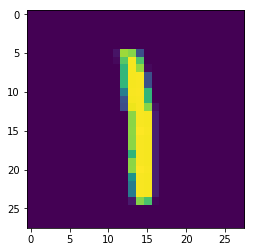

In [61]:
index = 37

print "True Value:", y_test[index]
plt.imshow(X_test[index])

print "\nPredicted Value:", np.argmax(model.predict(X_test[index].reshape(1,28,28,1)))